# Distributed Credit Analysis

## Environment set up

In [1]:
import os
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jdk1.8.0_202"
os.environ["SPARK_HOME"] = "C:/Spark/spark-3.0.3-bin-hadoop2.7"
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Individuazione dell'istanza locale di spark
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession

# Inizializzazione della sessione di Spark e lettura del csv in un dataframe
spark = SparkSession.builder.appName('Imbalanced_ML').getOrCreate()
df = spark.read.csv('../data/application_train.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [4]:
spark

# Data Understanding

In [5]:
# Drop di SK_ID_CURR per via della sua poca significatività
drop_col = ['SK_ID_CURR']
df = df.select([column for column in df.columns if column not in drop_col])
# Renaming della variabile target
df = df.withColumnRenamed('TARGET', 'label')

In [6]:
# Comprensione della distribuzione delle classi
df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


307511


<AxesSubplot:xlabel='label', ylabel='count'>

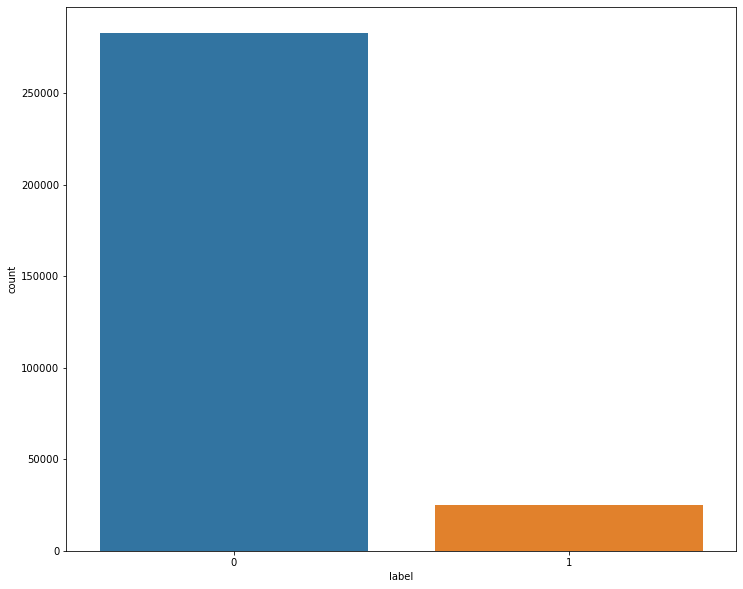

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_pd = df.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)

Si evidenziano due classi altamente sbilanciate 
- 91% classe 0
- 9% classe 1

In [21]:
# Overview sulla struttura dei dati
import pandas as pd
pd.DataFrame(df.take(10), columns= df.columns)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Data Preparation
## Missing values

In [22]:
# Check sul numero di variabili categoriche e numeriche
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  features categoriche')

num_cols = [item[0] for item in df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  features numeriche')

16  features categoriche
104  features numeriche


In [23]:
# Funzione utile alla scoperta di maggiori informazioni relative ai valori missing
def info_missing_table(df_pd):
    # Count dei valori missing totali nel dataframe
    mis_val = df_pd.isnull().sum()
    # Count in percentuale dei valori null in ogni colonna
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    # Renaming delle colonne nella tabella
    columns = {0 : 'Valori missing', 1 : '% del totale'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% del totale', ascending=False).round(1)         
    print ("Il dataframe ha " + str(df_pd.shape[1]) + " colonne.\n" 
    "Ci sono " + str(mis_val_table_ren_columns.shape[0]) + " colonne contenenti valori missing.")
    return mis_val_table_ren_columns

In [24]:
missings = info_missing_table(df_pd)
missings

Il dataframe ha 121 colonne.
Ci sono 67 colonne contenenti valori missing.


,Valori missing,% del totale
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [25]:
# Funzione utile ad ottenere informazioni sui dati missing all'interno del dataframe Spark
def count_missings(spark_df):
    null_counts = []        
    for col in spark_df.dtypes:    
        cname = col[0]     
        ctype = col[1]
        # Count dei valori null
        nulls = spark_df.where( spark_df[cname].isNull()).count()
        result = tuple([cname, nulls])
        # Tupla nella result list
        null_counts.append(result)
    # Restituzione solo delle colonne aventi valori missing
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]
    return null_counts

In [26]:
miss_counts = count_missings(df)
miss_counts

[('AMT_ANNUITY', 12),
 ('AMT_GOODS_PRICE', 278),
 ('NAME_TYPE_SUITE', 1292),
 ('OWN_CAR_AGE', 202929),
 ('OCCUPATION_TYPE', 96391),
 ('CNT_FAM_MEMBERS', 2),
 ('EXT_SOURCE_1', 173378),
 ('EXT_SOURCE_2', 660),
 ('EXT_SOURCE_3', 60965),
 ('APARTMENTS_AVG', 156061),
 ('BASEMENTAREA_AVG', 179943),
 ('YEARS_BEGINEXPLUATATION_AVG', 150007),
 ('YEARS_BUILD_AVG', 204488),
 ('COMMONAREA_AVG', 214865),
 ('ELEVATORS_AVG', 163891),
 ('ENTRANCES_AVG', 154828),
 ('FLOORSMAX_AVG', 153020),
 ('FLOORSMIN_AVG', 208642),
 ('LANDAREA_AVG', 182590),
 ('LIVINGAPARTMENTS_AVG', 210199),
 ('LIVINGAREA_AVG', 154350),
 ('NONLIVINGAPARTMENTS_AVG', 213514),
 ('NONLIVINGAREA_AVG', 169682),
 ('APARTMENTS_MODE', 156061),
 ('BASEMENTAREA_MODE', 179943),
 ('YEARS_BEGINEXPLUATATION_MODE', 150007),
 ('YEARS_BUILD_MODE', 204488),
 ('COMMONAREA_MODE', 214865),
 ('ELEVATORS_MODE', 163891),
 ('ENTRANCES_MODE', 154828),
 ('FLOORSMAX_MODE', 153020),
 ('FLOORSMIN_MODE', 208642),
 ('LANDAREA_MODE', 182590),
 ('LIVINGAPARTMENTS_MO

In [27]:
# Separazione delle colonne contenenti valori missing in un df a parte per feature categoriche e numeriche
list_cols_miss=[x[0] for x in miss_counts]
df_miss= df.select(*list_cols_miss)
# Features categoriche
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]
print("Feature categoriche con valori missing:", catcolums_miss)
# Features numeriche
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')]
print("Feature numeriche con valori missing:", numcolumns_miss)

Feature categoriche con valori missing: ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
Feature numeriche con valori missing: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MED

In [28]:
# Fill dei valori categorici missing con il valore più frequente
from pyspark.sql.functions import rank,sum,col
df_Nomiss=df.na.drop()
for x in catcolums_miss:
    mode = df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x,"- Valore più frequente: " , mode)
    df = df.na.fill({x:mode}) 

NAME_TYPE_SUITE - Valore più frequente:  Unaccompanied
OCCUPATION_TYPE - Valore più frequente:  Laborers
FONDKAPREMONT_MODE - Valore più frequente:  reg oper account
HOUSETYPE_MODE - Valore più frequente:  block of flats
WALLSMATERIAL_MODE - Valore più frequente:  Panel
EMERGENCYSTATE_MODE - Valore più frequente:  No


In [29]:
# Fill dei valori numerici missing con la media della relativa colonna
from pyspark.sql.functions import mean, round

for i in numcolumns_miss:
    meanvalue = df.select(round(mean(i))).collect()[0][0] 
    print(i,"- Valore medio: " , meanvalue) 
    df=df.na.fill({i:meanvalue}) 

AMT_ANNUITY - Valore medio:  27109.0
AMT_GOODS_PRICE - Valore medio:  538396.0
OWN_CAR_AGE - Valore medio:  12.0
CNT_FAM_MEMBERS - Valore medio:  2.0
EXT_SOURCE_1 - Valore medio:  1.0
EXT_SOURCE_2 - Valore medio:  1.0
EXT_SOURCE_3 - Valore medio:  1.0
APARTMENTS_AVG - Valore medio:  0.0
BASEMENTAREA_AVG - Valore medio:  0.0
YEARS_BEGINEXPLUATATION_AVG - Valore medio:  1.0
YEARS_BUILD_AVG - Valore medio:  1.0
COMMONAREA_AVG - Valore medio:  0.0
ELEVATORS_AVG - Valore medio:  0.0
ENTRANCES_AVG - Valore medio:  0.0
FLOORSMAX_AVG - Valore medio:  0.0
FLOORSMIN_AVG - Valore medio:  0.0
LANDAREA_AVG - Valore medio:  0.0
LIVINGAPARTMENTS_AVG - Valore medio:  0.0
LIVINGAREA_AVG - Valore medio:  0.0
NONLIVINGAPARTMENTS_AVG - Valore medio:  0.0
NONLIVINGAREA_AVG - Valore medio:  0.0
APARTMENTS_MODE - Valore medio:  0.0
BASEMENTAREA_MODE - Valore medio:  0.0
YEARS_BEGINEXPLUATATION_MODE - Valore medio:  1.0
YEARS_BUILD_MODE - Valore medio:  1.0
COMMONAREA_MODE - Valore medio:  0.0
ELEVATORS_MODE 

## Imbalanced classes

In [30]:
from pyspark.sql.functions import col, explode, array, lit

major_df = df.filter(col("label") == 0)
minor_df = df.filter(col("label") == 1)
ratio = int(major_df.count()/minor_df.count())
print("La classe di maggioranza è {} volte più numerosa di quella di minoranza".format(ratio))

a = range(ratio)
# Duplicazione delle righe appartenenti alla classe di minoranza
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# Combinazione del dataset oversampled e del dataset afferente alla classe di maggioranza
df = major_df.unionAll(oversampled_df)

# Comprensione della nuova distribuzione delle classi
df.groupby('label').count().toPandas()

ratio: 11


,label,count
0,1,273075
1,0,282686


In [32]:
# Verifica finale dei valori missing nel dataset
miss_counts2 = count_missings(df)
miss_counts2

[]

## Feature engineering

In [33]:
# OneHotEncoder messo a disposizione da MLlib di Spark per convertire le variabili categoriche in vettori one-hot
# VectorAssembler utilizzato per combinare i vettori ottenuti con le feature numeriche in un unica colonna
# Creazione delli stages utili alla creazione della pipeline finale
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [34]:
stages

[StringIndexer_f3b79f59e746,
 OneHotEncoder_6808f5f55ca2,
 StringIndexer_834b22570412,
 OneHotEncoder_1b9a6d9a29e2,
 StringIndexer_f473e375af08,
 OneHotEncoder_5df42c201501,
 StringIndexer_480378472f7d,
 OneHotEncoder_657d4b6b621e,
 StringIndexer_f5590c9d02ab,
 OneHotEncoder_c72942a00bf0,
 StringIndexer_f25436abea14,
 OneHotEncoder_d023009bf1f3,
 StringIndexer_7ebb40c21a79,
 OneHotEncoder_47080c288841,
 StringIndexer_c0ba2db963e0,
 OneHotEncoder_4790c8870255,
 StringIndexer_51b1ce2d7f0c,
 OneHotEncoder_d5e6e74682e7,
 StringIndexer_8b1226aac155,
 OneHotEncoder_116a2f3b2baf,
 StringIndexer_338b3fa7c305,
 OneHotEncoder_3868d555d2ff,
 StringIndexer_c5c35827f2ea,
 OneHotEncoder_7543ce4a2a80,
 StringIndexer_dd7b6075c3de,
 OneHotEncoder_2977ed9e80f1,
 StringIndexer_7b7a12001e18,
 OneHotEncoder_8dcc63421d88,
 StringIndexer_3532e23adcfe,
 OneHotEncoder_79a3a2621c6e,
 StringIndexer_85bb5b63f5a1,
 OneHotEncoder_111ea3942944,
 VectorAssembler_44133c9a3d0e]

In [35]:
# Pipeline per applicare tutti gli stages di trasformazione definiti precedentemente ai dati
from pyspark.ml import Pipeline
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

In [36]:
selectedCols = ['features']+cols
df = df.select(selectedCols)
# Check alla struttura finale del dataset alla fine del processo
pd.DataFrame(df.take(5), columns=df.columns)

,features,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,"(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
3,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,"(1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [37]:
# Split del dataset in train e test per lo step di modellazione
train, test = df.randomSplit([0.70, 0.30], seed = 42)
print("#Dati di training: ",train.count())
print("#Dati di test: ",test.count())

#Dati di training:  389567
#Dati di test:  166194


# Modelling

## Logistic regression

In [38]:
from pyspark.ml.classification import LogisticRegression
# Fit del modello
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

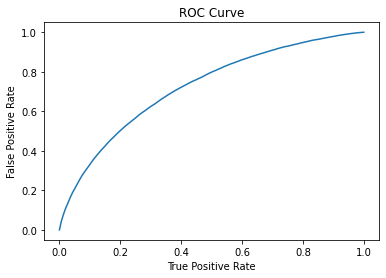

Training set ROC: 0.7221321427470865


In [39]:
# Curva ROC 
trainingSummary = LR_model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Valutazione del modello
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test set Area Under ROC: " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test set Area Under ROC: 0.7211762543803605


## Decision Tree Classifier

In [41]:
from pyspark.ml.classification import DecisionTreeClassifier
# Fit del modello
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)


In [42]:
# Valutazione del modello
predictions = dtModel.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5832047971102231


## Random Forest Classifier

In [43]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

In [44]:
# Valutazione del modello
predictions = rfModel.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.686364915542119


## Gradient boosting classifier

In [45]:
from pyspark.ml.classification import GBTClassifier
# Fit del modello
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)

In [46]:
# Valutazione del modello
predictions = GBT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test set Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test set Area Under ROC: 0.7457740992971185


## Hyperparameter Tuning

In [47]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Hyperparameter Tuning
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 30])
             .addGrid(gbt.maxIter, [10, 15])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Cross Validation
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.7554406075075196

In [50]:
res = zip(cvModel.avgMetrics, paramGrid)

In [51]:
list(res)

[(0.7158032004949976,
  {Param(parent='GBTClassifier_6c242db78a21', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='GBTClassifier_6c242db78a21', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20,
   Param(parent='GBTClassifier_6c242db78a21', name='maxIter', doc='max number of iterations (>= 0).'): 10}),
 (0.7195729234167203,
  {Param(parent='GBTClassifier_6c242db78a21', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='GBTClassifier_6c242db78a21', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20,
   Param(parent='GBTClassifier_6c242db78a21', name='maxIter', doc='max 